# How does the number of synapses into/out of a neuron depend on the neuron's neurotransmitter

[Wang _et al._, 2024](https://doi.org/10.1101/2024.09.24.614724) found that the optimal functional complexity of the larval Drosophila network was achieved with a ~4:1 excitatory to inhibitory neuron ratio, but with the inhibitory neurons having higher numbers of inputs.

Do we see this in VNC?

In [11]:
%load_ext autoreload
%autoreload 2

from connections import Connections
from connectome_reader import ConnectomeReader
from plotnine import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
CR = ConnectomeReader('v1.0', 'MANC')
connections = Connections(CR=CR)  # entire datasets

Attribute class_1 not found in the graph. Adding it.


In [12]:
details = CR.load_data_neuron_set(
    connections.get_neuron_bodyids(),
    [
        "nt_type",
        "nb_pre_neurons",
        "nb_post_neurons",
		"class_1",
    ],
)
details.loc[details["nt_type"].isna(), "nt_type"] = "None"
details

nb_pre_neurons  --->  upstream:int
nb_post_neurons  --->  downstream:int


,nt_type,nb_pre_neurons,nb_post_neurons,class_1,body_id
2,acetylcholine,785,2345,sensory neuron,156353
5,unknown,2482,14,motor neuron,13999
6,glutamate,563,32,efferent neuron,14571
7,unknown,1155,12,motor neuron,23801
8,glutamate,1335,12,motor neuron,13733
...,...,...,...,...,...
23568783,acetylcholine,188,1649,descending neuron,31635
23596997,acetylcholine,3,43,descending neuron,151717
23761553,glutamate,28,165,descending neuron,49317
23826295,glutamate,226,1666,descending neuron,10023


In [13]:
details["nt_type"].value_counts()


nt_type
acetylcholine    11471
glutamate         5855
gaba              5787
None               124
unknown            106
Name: count, dtype: int64

Here we don't see the 4:1 ratio - there are 11675 excitatory neurons (acetylcholine) and 7268 inhibitory neurons (gaba) so it's more like 2:1. We ignore all the glutamate neurons, and the unknown ones.

I'm not sure why there are 340K neurons with None as the neurotransmitter, so I remove them...

In [15]:
details = details.loc[details["nt_type"] != "None"]

In [16]:
details.loc[:, ["nt_type", "nb_pre_neurons", "nb_post_neurons"]].groupby(
    "nt_type"
).mean()


,nb_pre_neurons,nb_post_neurons
nt_type,,
acetylcholine,1320.956761,3080.908639
gaba,1922.564541,3376.200276
glutamate,1212.346541,1859.837746
unknown,2304.698113,89.245283


We do see a higher mean in-degree for gaba synapses than acetylcholine, whereas the out-degrees are fairly similar. Let's check the full distributions.

/home/hurtak/miniconda3/envs/vnc/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/home/hurtak/miniconda3/envs/vnc/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 5 rows containing non-finite values.


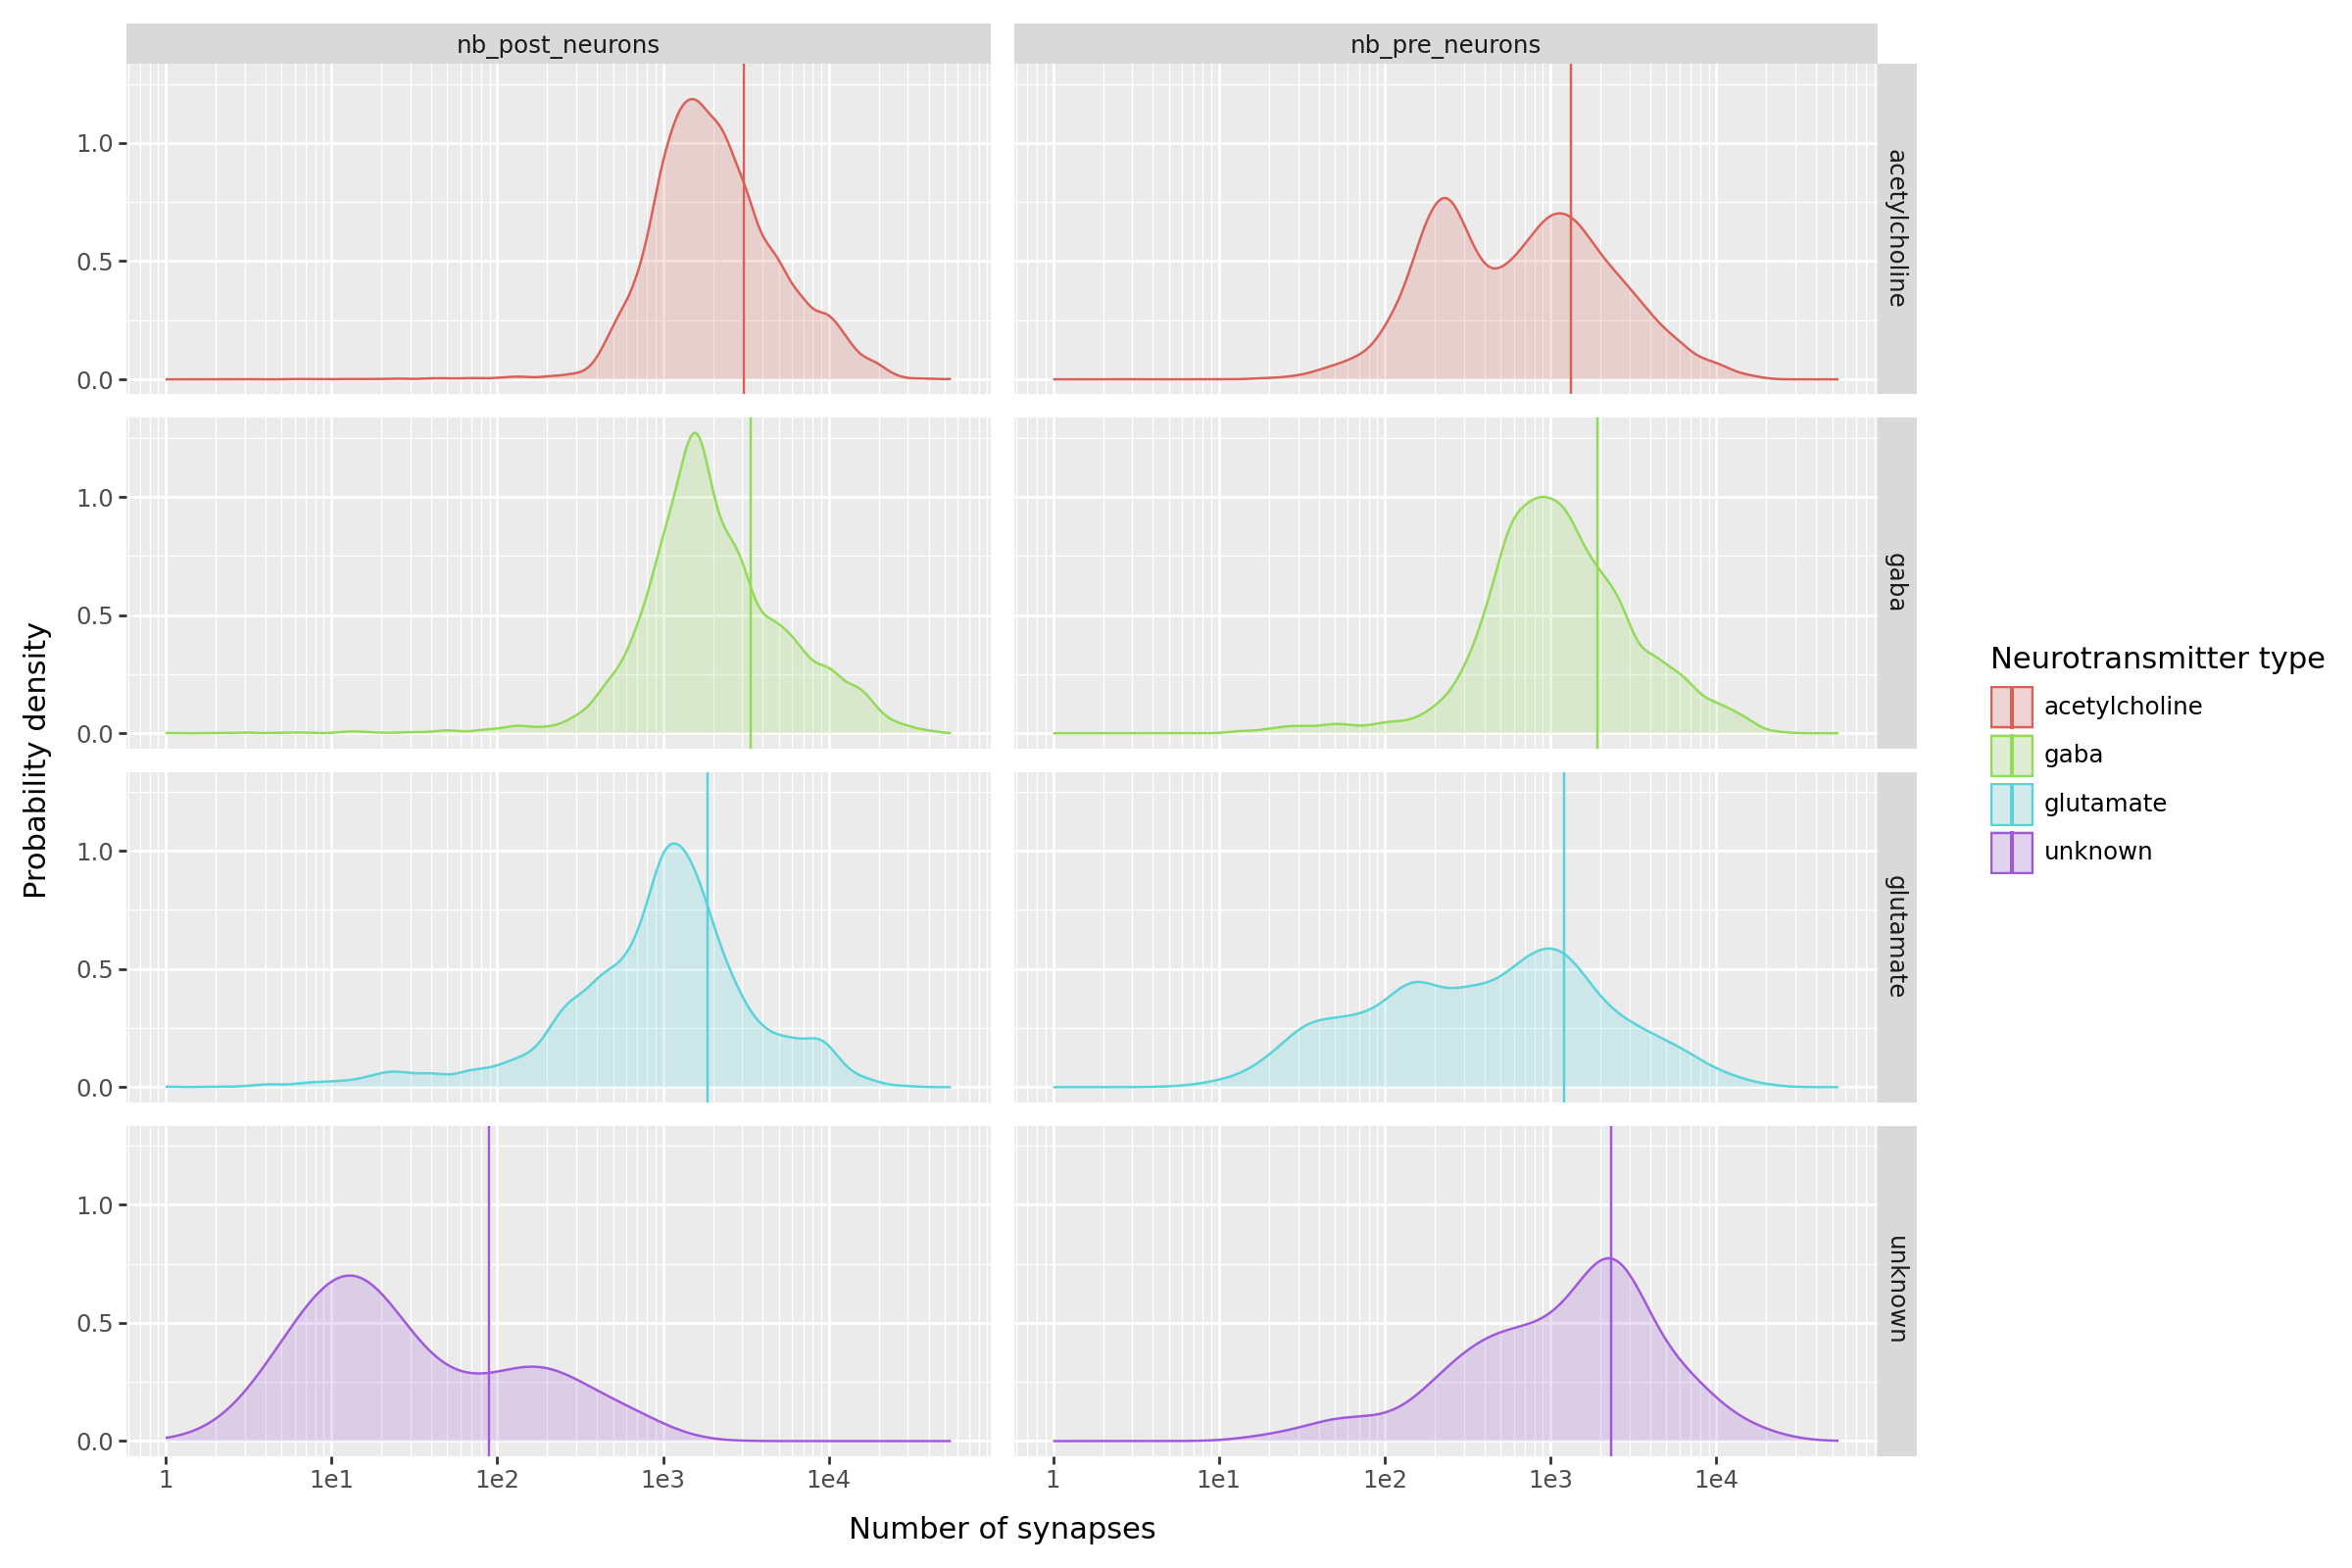

In [17]:
(
    ggplot(
        details.melt("nt_type", ["nb_pre_neurons", "nb_post_neurons"]),
        aes(
            x="value",
            color="nt_type",
            fill="nt_type",
        ),
    )
    + facet_grid(rows="nt_type", cols="variable")
    + geom_density(alpha=0.2)
    + geom_vline(
        aes(xintercept="value", color="nt_type"),
        details.loc[:, ["nt_type", "nb_pre_neurons", "nb_post_neurons"]]
        .groupby("nt_type")
        .mean()
        .reset_index()
        .melt("nt_type"),
    )
    + scale_x_log10()
    + labs(
        y="Probability density",
        x="Number of synapses",
        color="Neurotransmitter type",
        fill="Neurotransmitter type",
    )
    + theme(figure_size=(12, 8))
)


So while the mean of the gaba in degree is higher, it looks to be because the acetylcholine in degree distribution is bimodal

We can see it more clearly if we overlay the distributions

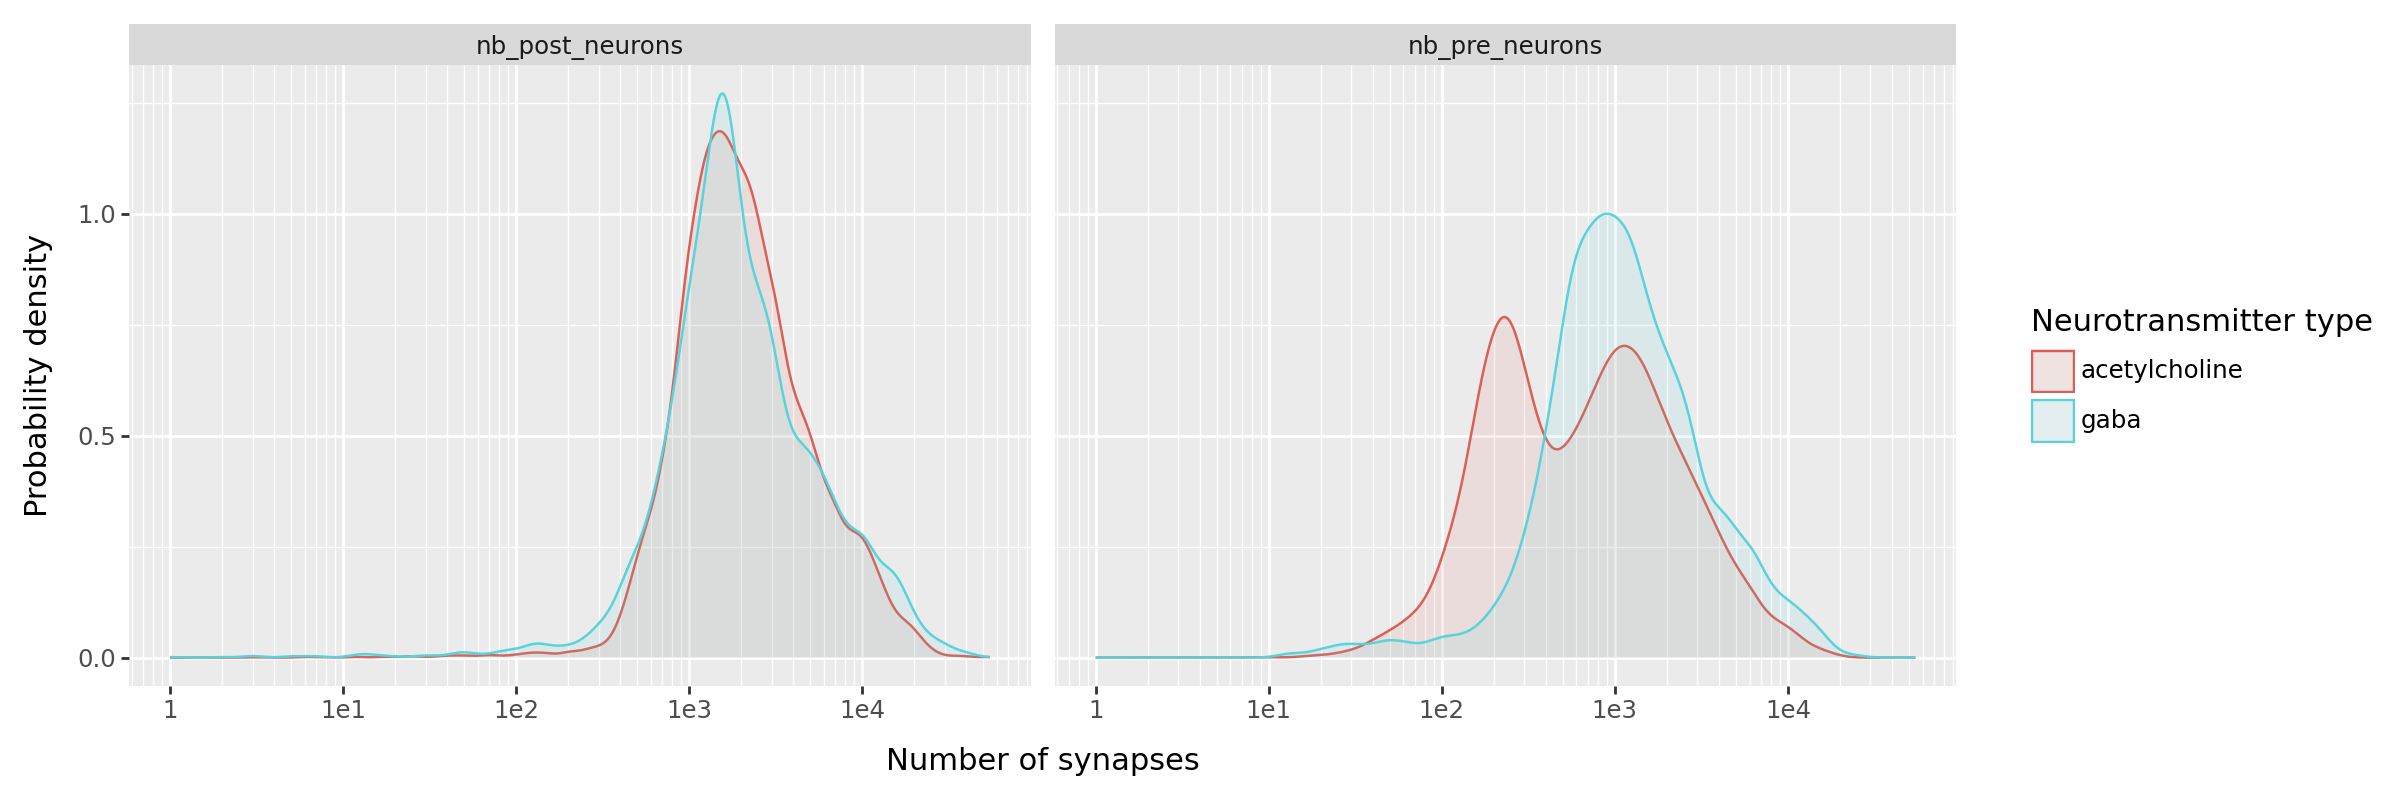

In [18]:
(
    ggplot(
        details[details["nt_type"].isin(["acetylcholine", "gaba"])].melt(
            "nt_type", ["nb_pre_neurons", "nb_post_neurons"]
        ),
        aes(
            x="value",
            color="nt_type",
            fill="nt_type",
        ),
    )
    + facet_wrap("variable")
    + geom_density(alpha=0.1)
    + scale_x_log10()
    + labs(
        y="Probability density",
        x="Number of synapses",
        color="Neurotransmitter type",
        fill="Neurotransmitter type",
    )
    + theme(figure_size=(12, 4))
)


Where does this bimodal distribution come from? Let's break down the in degree distributions based on neuron class. Maybe that plays a role?

In [19]:
classes_of_acetylcholine_neurons = details[
    (details["nt_type"] == "acetylcholine")
    & (~details["class_1"].isna())
]["class_1"].value_counts()

classes_of_acetylcholine_neurons

class_1
intrinsic neuron     5318
sensory neuron       3467
ascending neuron     1231
descending neuron     937
sensory ascending     476
motor neuron           33
efferent neuron         6
Interneuron TBD         3
Name: count, dtype: int64

In [20]:
most_import_neuron_classes = classes_of_acetylcholine_neurons.index[
    classes_of_acetylcholine_neurons.values > 10]

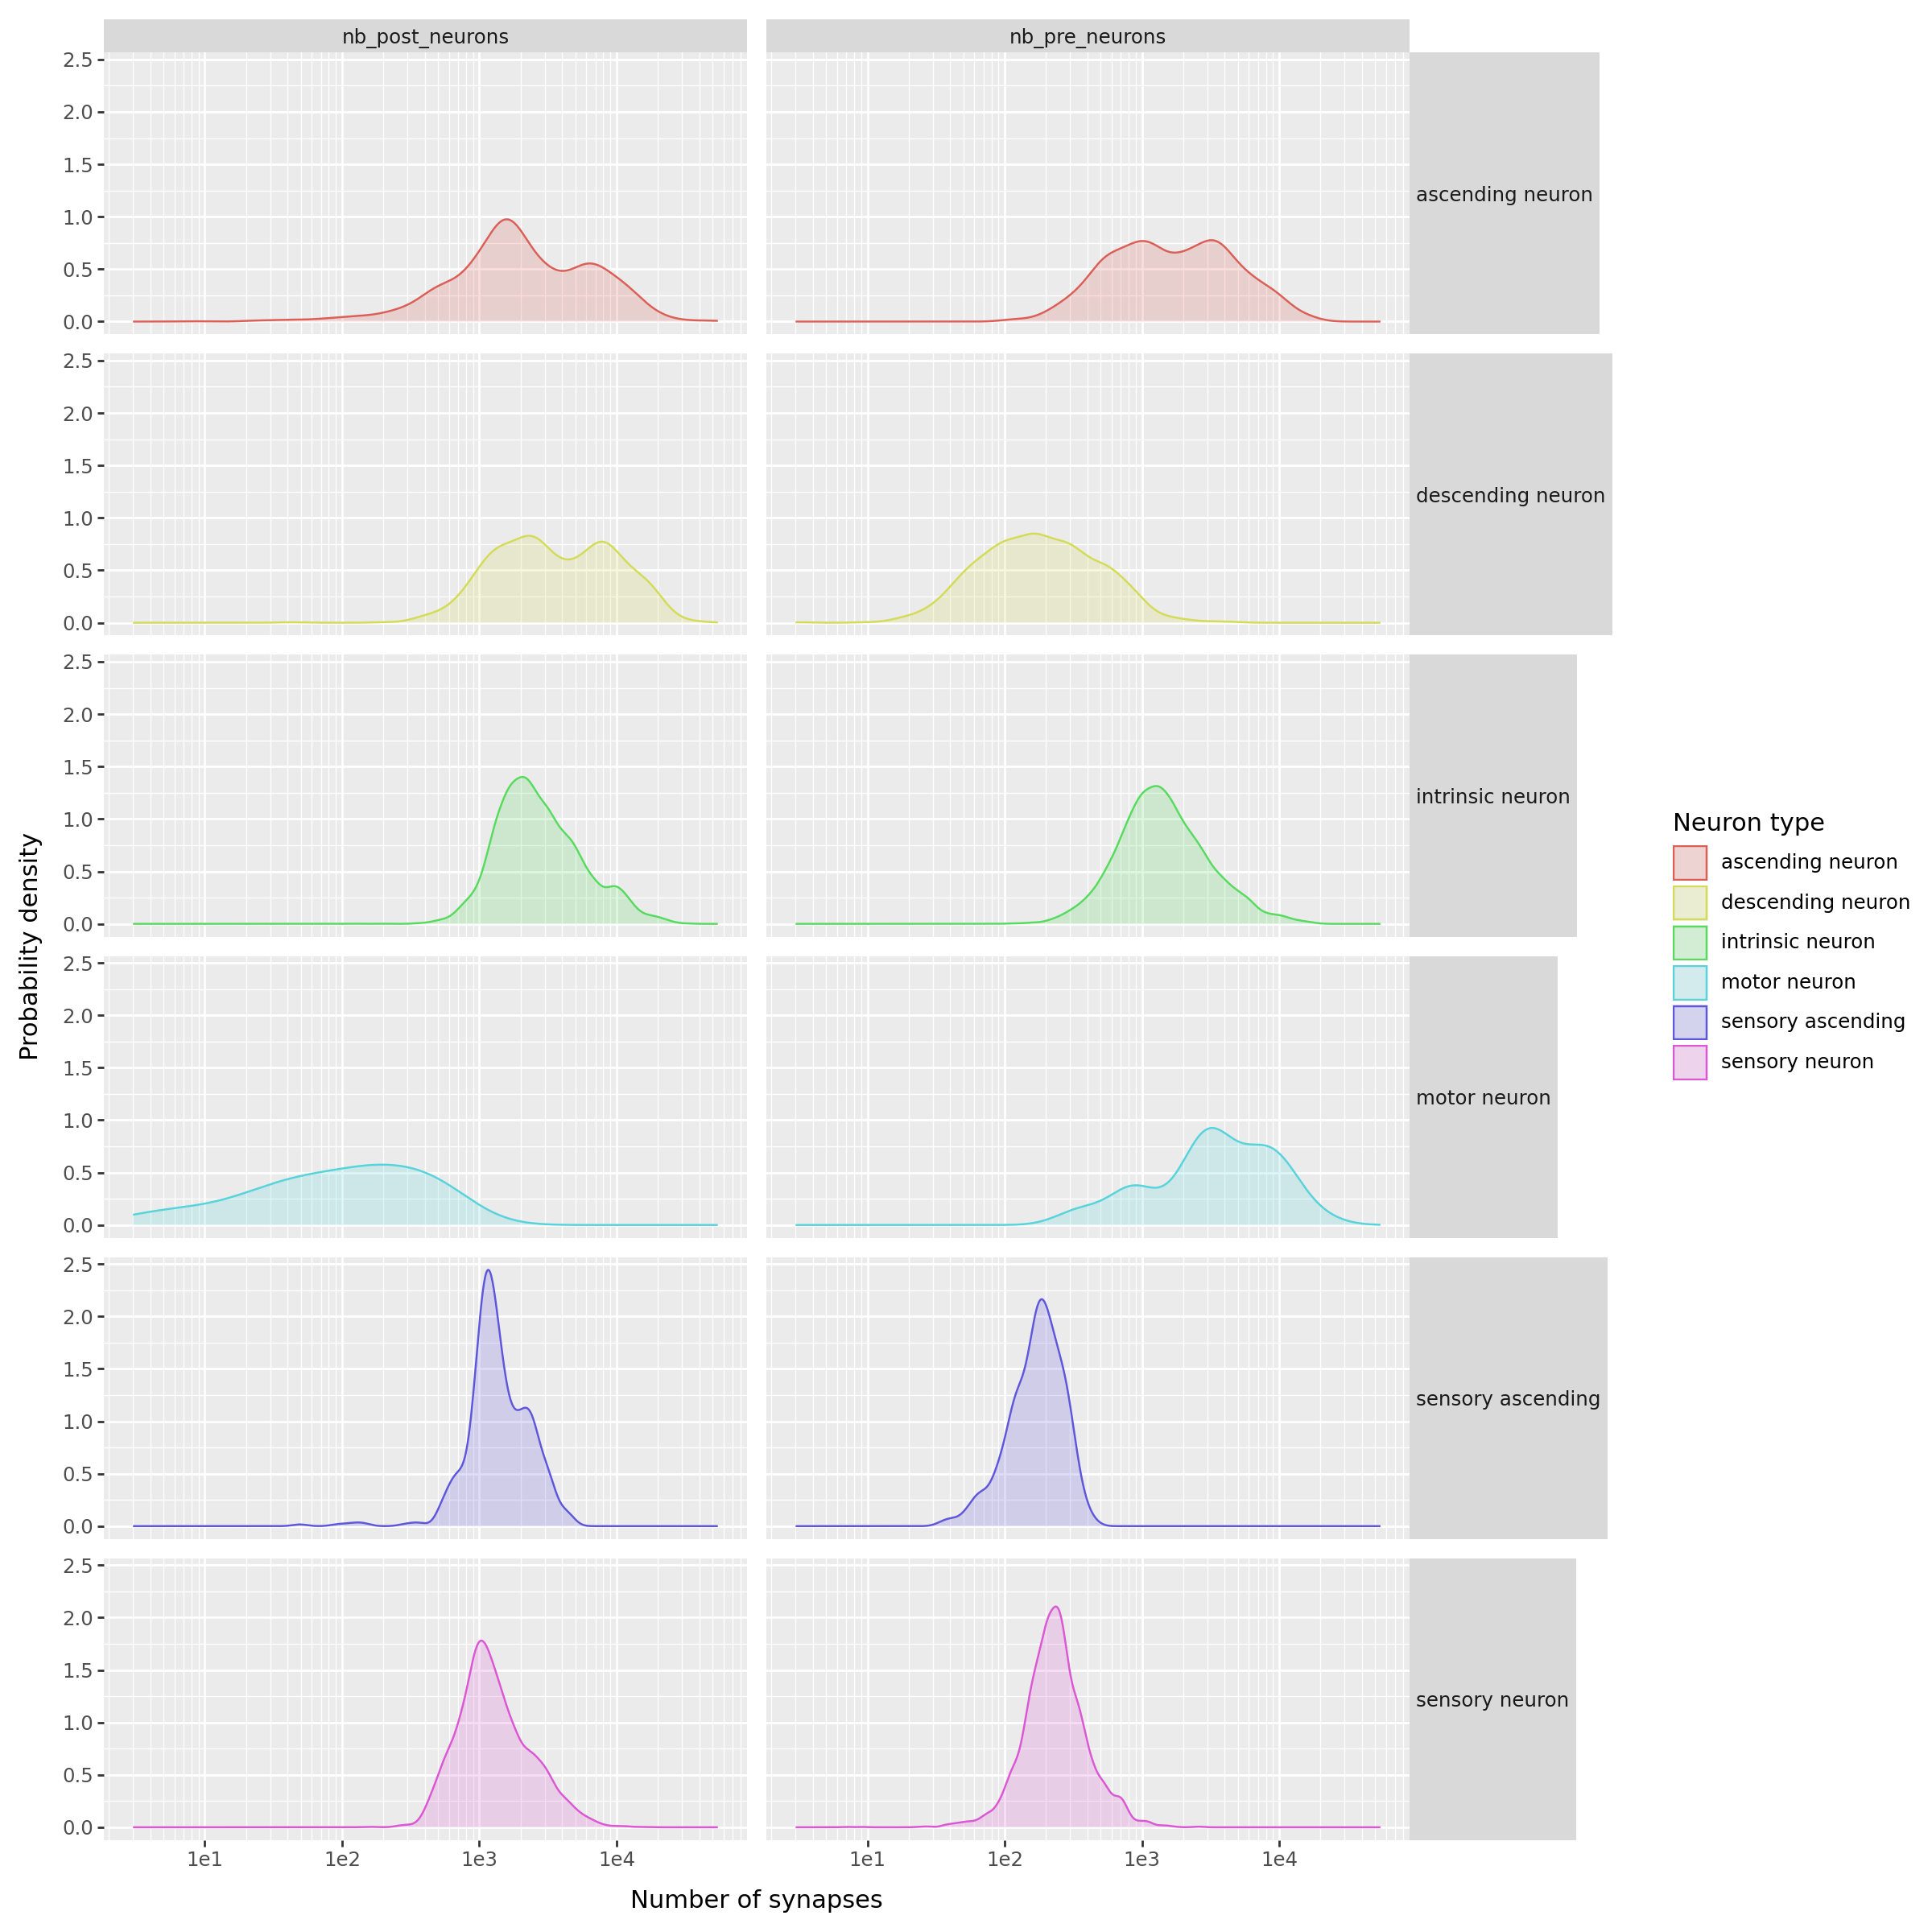

In [21]:
(
    ggplot(
        details[
            (details["nt_type"] == "acetylcholine")
            & (details["class_1"].isin(most_import_neuron_classes))
        ].melt("class_1", ["nb_pre_neurons", "nb_post_neurons"]),
        aes(
            x="value",
            color="class_1",
            fill="class_1",
        ),
    )
    + facet_grid(rows="class_1", cols="variable")
    + geom_density(alpha=0.2)
    + scale_x_log10()
    + labs(
        y="Probability density",
        x="Number of synapses",
        color="Neuron type",
        fill="Neuron type",
    )
    + theme(figure_size=(12, 12), strip_text_y=element_text(angle=0))
)


Now we can see that the lower in-degree acetylcholine neurons are sensory and DNs, while the higher in-degree neurons are instrinic, ANs, and motor neurons. For ANs, DNs, and MNs, this makes sense. It's interesting that sensory neurons don't have a low number of inputs though...

We can also see that the number of incoming and outgoing synapses correlates well for each neuron type individually, but that they have different ranges for the number of incoming synapses

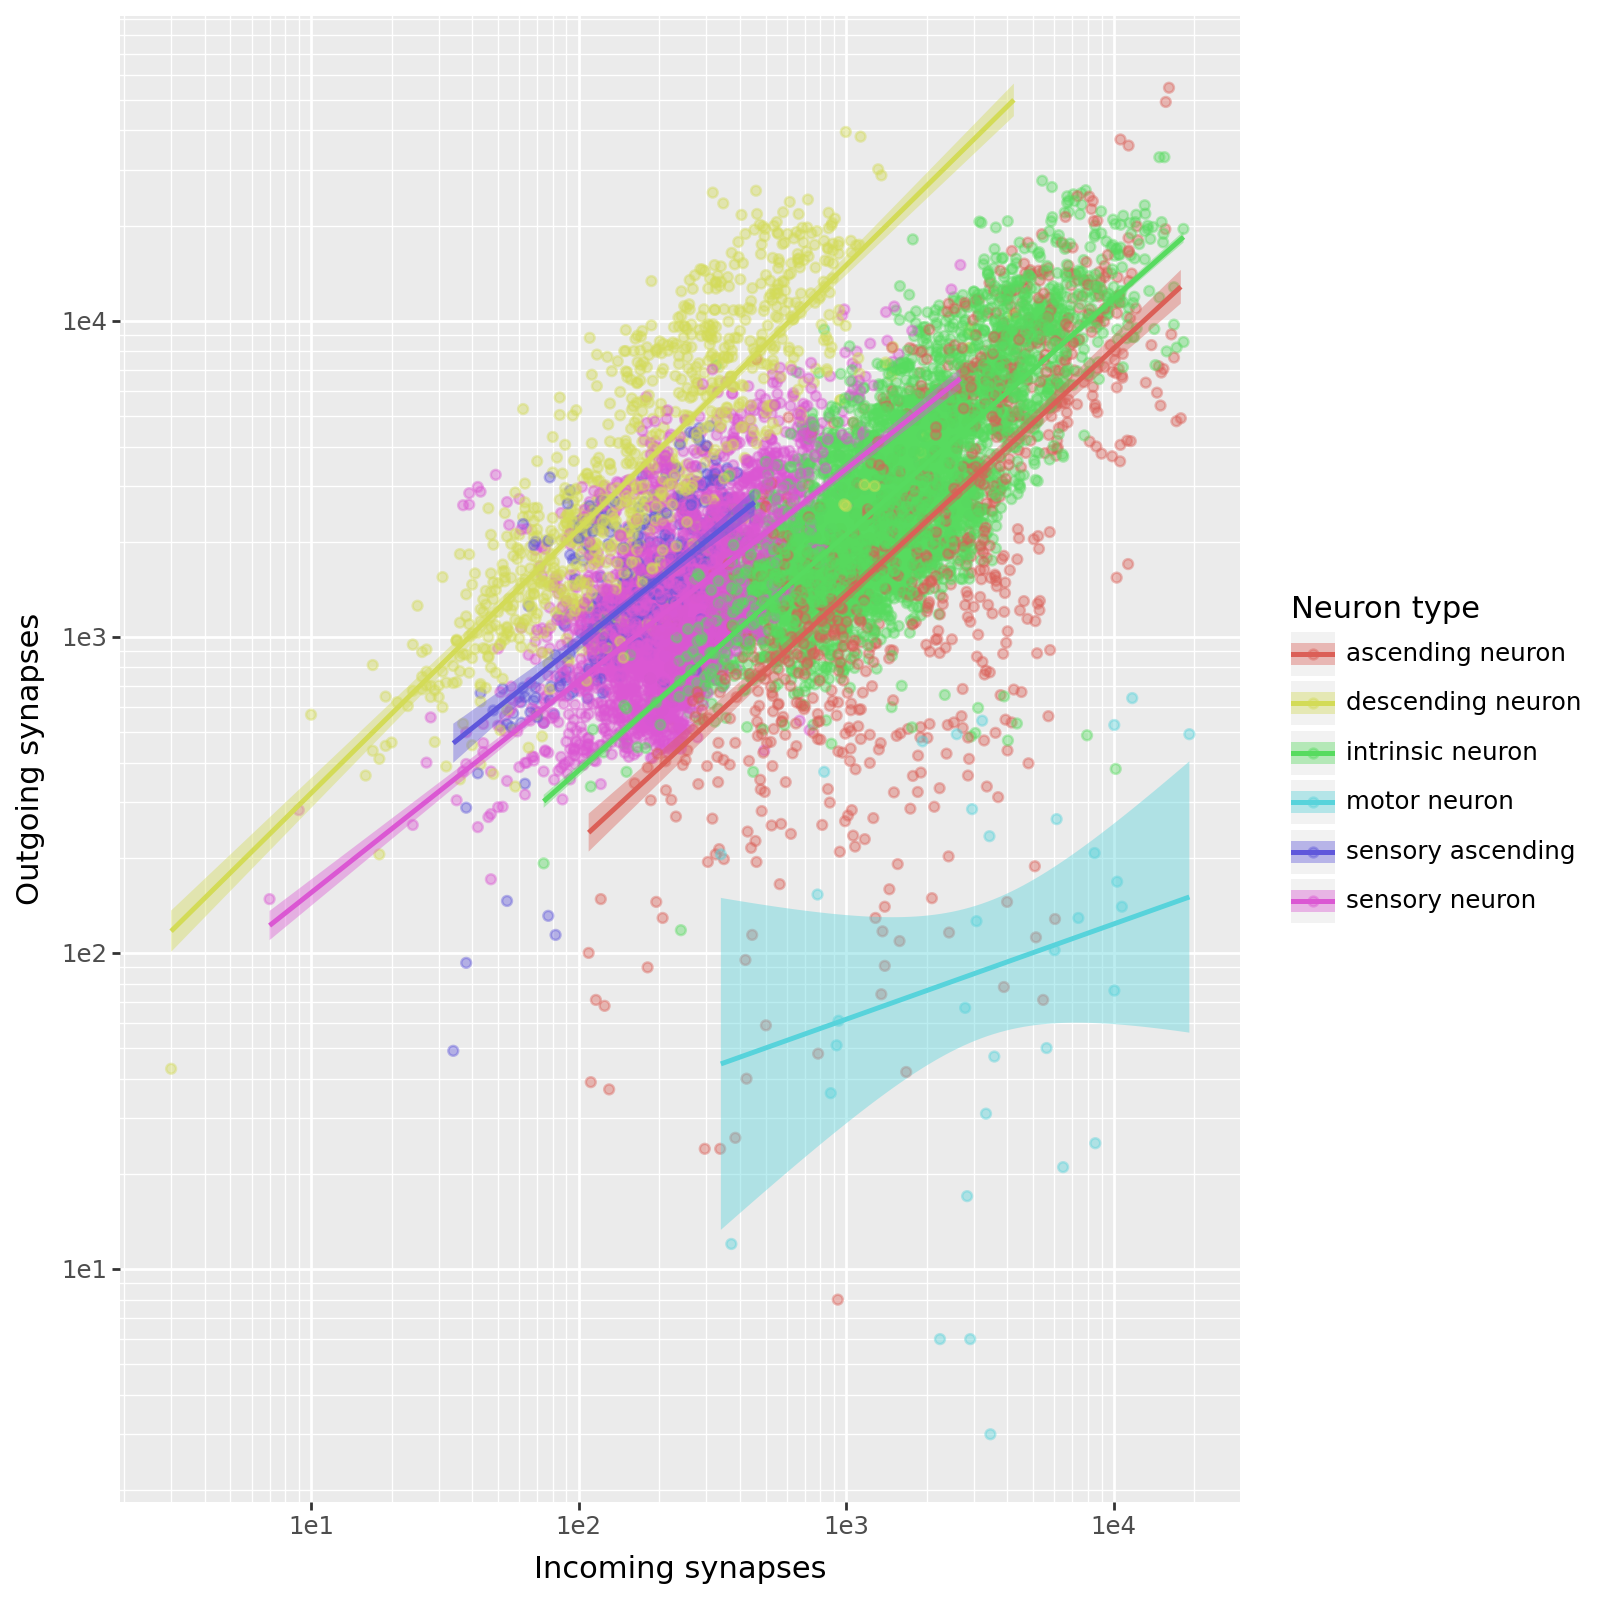

In [22]:
(
    ggplot(
        details[
            (details["nt_type"] == "acetylcholine")
            & (details["class_1"].isin(most_import_neuron_classes))
        ],
        aes(
            x="nb_pre_neurons",
            y="nb_post_neurons",
            color="class_1",
            fill="class_1",
        ),
    )
    + geom_point(alpha=0.4)
	+ geom_smooth()
    + scale_x_log10()
    + scale_y_log10()
    + theme(figure_size=(8, 8))
	+ labs(
        x="Incoming synapses",
        y="Outgoing synapses",
        color="Neuron type",
        fill="Neuron type",
    )
)